# baseline_optim.ipynb
---

#### Jack McShane
#### Rahul Shamdasani

### Imports

In [101]:
import torch
import torchvision as tv
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sklearn.metrics as metrics

In [102]:
# imports for the network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as Var

In [103]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/pytorchtools.py .
!cp drive/MyDrive/plot_confusion_matrix.py .
from pytorchtools import EarlyStopping
from plot_confusion_matrix import plot_confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
"""
This source served as a great resource and a starting point for the code in this notebook

https://nextjournal.com/gkoehler/pytorch-mnist
"""

'\nThis source served as a great resource and a starting point for the code in this notebook\n\nhttps://nextjournal.com/gkoehler/pytorch-mnist\n'

In [105]:
"""
inspiration for the code used below comes from these sources:

https://pytorch.org/docs/stable/notes/randomness.html
"""

# setting random seed for repeatable results
rand_seed = 5
torch.manual_seed(rand_seed)
random.seed(rand_seed)
np.random.seed(rand_seed)

## Definitions

### Defining Network Structure(s)

In [106]:
# defining hyperparameters for the network
class hyp:
  n_epochs = 50
  batch_size = 100
  momentum = .9
  pat = 10
  lr = .05
  nfc1_inputs = 12*5*5 # using 4x4 filters and stride of two, the dimensionailty of the feature maps is 5x5 after two convolutional layers (there are 12 of them)
  nnodes_fc1 = 30
  nnodes_fc2 = 10

In [107]:
"""
inspiration for the code used below comes from these sources:

https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
https://stackoverflow.com/questions/61116355/interpretation-of-in-channels-and-out-channels-in-conv2d-in-pytorch-convolution
https://pytorch.org/docs/stable/generated/torch.nn.Module.html
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
https://stackoverflow.com/questions/63779798/adding-xavier-initiliazation-in-pytorch
https://pytorch.org/docs/master/nn.init.html?highlight=init
"""

# building the network
class CNN(nn.Module):
  # overwrite init func
  def __init__(self):
    super(CNN, self).__init__()

    # defining network architecture
    self.net = nn.Sequential(
        # first layer -- convolutional
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(4,4), stride=2),
        nn.ReLU(),

        # second layer -- convolutional
        nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(4,4), stride=2),
        nn.ReLU(),
        nn.Flatten(), # flattens the layer's output for use in the first linear layer

        # third layer -- fully connected
        nn.Linear(hyp.nfc1_inputs, hyp.nnodes_fc1),
        nn.ReLU(),

        # fourth layer -- fully connected
        nn.Linear(hyp.nnodes_fc1, hyp.nnodes_fc2)
    )


    # initializing network weights using Glorot initialization
    torch.nn.init.xavier_uniform_(self.net[0].weight)
    torch.nn.init.xavier_uniform_(self.net[2].weight)
    torch.nn.init.xavier_uniform_(self.net[5].weight)
    torch.nn.init.xavier_uniform_(self.net[7].weight)




  # defining the forward pass for the network
  def forward(self, data):
    return self.net(data)


### Function Definitions (Training, Validation, Testing)

In [108]:
"""
inspiration for the code used below comes from these sources:

https://github.com/Bjarten/early-stopping-pytorch
https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
"""


# Training the CNN
def train(net, lfunc, opt):
  #training
  ncorrect = 0 # correct predictions accross the epoch
  nsamples = 0
  tot_loss = 0.0

  net.train(True)
  with torch.set_grad_enabled(True):
    for batch, labels in train_gen:
      opt.zero_grad() # zero out accumulated gradients


      batch, labels = Var(batch.float()), Var(labels.float())
      out = net(batch)

      loss = lfunc(out, labels.long()) # returns avg loss for the batch
      tot_loss += loss * hyp.batch_size

      # backprop
      loss.backward() # grad calc
      opt.step() # update weights

      selected_class = torch.argmax(out, dim=1)
      ncorrect += selected_class.eq(labels).sum().item()
      nsamples += hyp.batch_size

    # epoch calculations
    avg_loss = tot_loss / len(train_gen.dataset)
    accuracy = ncorrect / nsamples
    return avg_loss, accuracy



# Validation func
def val(net, lfunc):
  ncorrect = 0
  nsamples = 0
  tot_loss = 0.0
  
  with torch.set_grad_enabled(False):
    net.eval()
    for batch, labels in val_gen:

      batch, labels = Var(batch.float()), Var(labels.float())
      out = net(batch) # network output
      # loss calc
      loss = lfunc(out, labels.long())
      tot_loss += loss * hyp.batch_size

      selected_class = torch.argmax(out, dim=1)
      ncorrect += selected_class.eq(labels).sum().item()
      nsamples += hyp.batch_size

    # epoch calculations
    avg_loss = tot_loss / len(val_gen.dataset)
    accuracy = ncorrect / nsamples
    return avg_loss, accuracy





def train_val(net, lfunc, opt, sched=None):
  epochs_run = 0
  train_loss = list()
  train_accuracy = list()
  val_loss = list()
  val_accuracy = list()
  early_stopping = EarlyStopping(patience=hyp.pat)
  for epoch in range(1, hyp.n_epochs + 1):
    # training
    tloss, taccuracy = train(net, lfunc, opt)
    train_loss.append(tloss)
    train_accuracy.append(taccuracy)

    # validation
    vloss, vaccuracy = val(net, lfunc)
    val_loss.append(vloss)
    val_accuracy.append(vaccuracy)

    # update and check
    epochs_run = epoch
    if sched is not None:
      sched.step()
    early_stopping(vloss, net)
    if early_stopping.early_stop:
      print('Validation loss has not changed: Stopping early.')
      break

  return epochs_run, train_loss, train_accuracy, val_loss, val_accuracy


In [109]:
# testing the CNN
def test(net, lfunc):
  tot_loss = 0.0
  ncorrect = 0
  nsamples = 0
  pred = list()
  y_test = list()

  with torch.set_grad_enabled(False):
    net.eval()

    for batch, labels in test_gen:

      batch, labels = Var(batch.float()), Var(labels.float())
      out = net(batch)

      loss = lfunc(out, labels.long())
      tot_loss += loss * len(labels)

      selected_class = torch.argmax(out, dim=1)
      pred += selected_class.tolist()
      y_test += labels.tolist()

      ncorrect += metrics.accuracy_score(labels, selected_class, normalize=False)
      nsamples += len(labels)

    test_loss = tot_loss / len(test_gen.dataset)
    test_acc = ncorrect / nsamples
    return pred, y_test, test_loss, test_acc


## Initialization, Training, Testing

### Preparing Datasets/Dataloaders

In [110]:
# importing and preparing the data for use

"""
inspiration for the code used below comes from these sources:

https://pytorch.org/vision/stable/datasets.html#mnist
"""
transform = tv.transforms.Compose([
                  tv.transforms.ToTensor(),
                  tv.transforms.Normalize((.1307,),(.3081))
])

dataset = tv.datasets.MNIST('/files/', train=True, download=True, transform=transform)
test_set = tv.datasets.MNIST('/files/', train=False, download=True, transform=transform)

"""
inspiration for the code used below comes from these sources:

https://discuss.pytorch.org/t/how-to-split-dataset-into-test-and-validation-sets/33987/4
https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887
"""
train_set, val_set = torch.utils.data.random_split(dataset, [50000,10000])


In [111]:
# verify that the train/val/test sets have the correct dimensions
print(len(train_set))
print(len(val_set))
print(len(test_set))

50000
10000
10000


In [112]:
# passing the dataset to dataloaders
train_gen = torch.utils.data.DataLoader(train_set, hyp.batch_size, shuffle=True)
val_gen = torch.utils.data.DataLoader(val_set, hyp.batch_size, shuffle=True)
test_gen = torch.utils.data.DataLoader(test_set, test_set.__len__(), shuffle=True)

### Initializing Network, Optimizer, Scheduler...

In [113]:
"""
inspiration for the code used below comes from these sources:

https://pytorch.org/docs/stable/optim.html?highlight=scheduler#torch.optim.lr_scheduler.StepLR
https://jamesmccaffrey.wordpress.com/2020/12/08/pytorch-learning-rate-scheduler-example/
"""

# initialize network, optimizer, and loss func
rms_cnn = CNN()
rms_cel = nn.CrossEntropyLoss()
rms_opt = optim.RMSprop(rms_cnn.parameters(), lr=hyp.lr, alpha=.9)
#rms_sched = optim.lr_scheduler.StepLR(rms_opt, step_size=10, gamma=.9)

adam_cnn = CNN()
adam_cel = nn.CrossEntropyLoss()
adam_opt = optim.Adam(adam_cnn.parameters(), lr=.001)
#adam_sched = optim.lr_scheduler.StepLR(adam_opt, step_size=10, gamma=.9)

nest_cnn = CNN()
nest_cel = nn.CrossEntropyLoss()
nest_opt = optim.SGD(nest_cnn.parameters(), lr=hyp.lr, momentum=hyp.momentum, nesterov=True)
nest_sched = optim.lr_scheduler.StepLR(nest_opt, step_size=10, gamma=.9)


### Train, Validate, Test

In [114]:
# RMS Prop
rms_results = train_val(rms_cnn, rms_cel, rms_opt)
rms_nepochs, rms_tr_loss, rms_tr_acc, rms_val_loss, rms_val_acc = rms_results

EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Validation loss has not changed: Stopping early.


In [115]:
rms_test_results = test(rms_cnn, rms_cel)
rms_pred, rms_y_test, rms_test_loss, rms_test_acc = rms_test_results

In [90]:
print('(RMS Prop) Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(rms_test_loss, rms_test_acc))

(RMS Prop) Test Loss: 2.302069902, Test Accuracy: 0.11350


In [35]:
# ADAM optimization
adam_results = train_val(adam_cnn, adam_cel, adam_opt)
adam_nepochs, adam_tr_loss, adam_tr_acc, adam_val_loss, adam_val_acc = adam_results

EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Validation loss has not changed: Stopping early.


In [36]:
adam_test_results = test(adam_cnn, adam_cel)
adam_pred, adam_y_test, adam_test_loss, adam_test_acc = adam_test_results

In [37]:
print('(Adam) Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(adam_test_loss, adam_test_acc))

(Adam) Test Loss: 0.047021806, Test Accuracy: 0.98800


In [39]:
# Nesterov Optimization
nest_results = train_val(nest_cnn, nest_cel, nest_opt, nest_sched)
nest_nepochs, nest_tr_loss, nest_tr_acc, nest_val_loss, nest_val_acc = nest_results

EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Validation loss has not changed: Stopping early.


In [40]:
nest_test_results = test(nest_cnn, nest_cel)
nest_pred, nest_y_test, nest_test_loss, nest_test_acc = nest_test_results

In [41]:
print('(Nesterov) Test Loss: {:>.9f}, Test Accuracy: {:>.5f}'.format(nest_test_loss, nest_test_acc))

(Nesterov) Test Loss: 0.112799853, Test Accuracy: 0.98210


## Results

### RMS Prop

#### Learning Curves

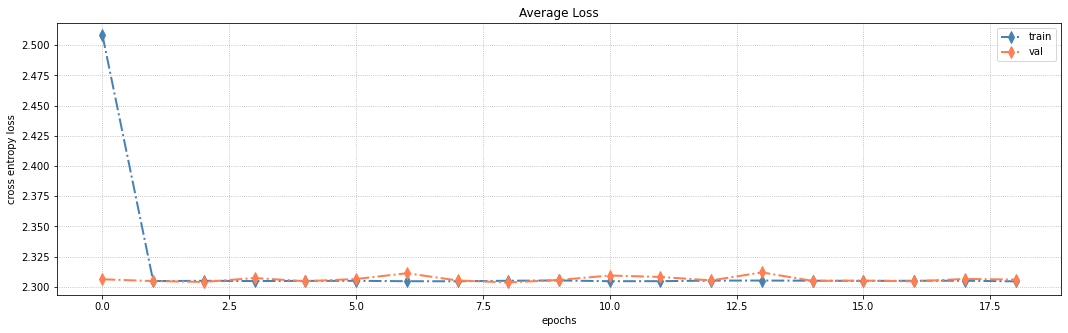

In [116]:
# plotting accuracy
fig, ax = plt.subplots(figsize=(18,5))
epochs = range(rms_nepochs)
ax.set_title('Average Loss')
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss')
ax.xaxis.grid(True,ls='dotted')
ax.yaxis.grid(True,ls='dotted')
ax.plot(epochs, rms_tr_loss, label='train', color='steelblue', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.plot(epochs, rms_val_loss, label='val', color='coral', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.legend()

plt.show()

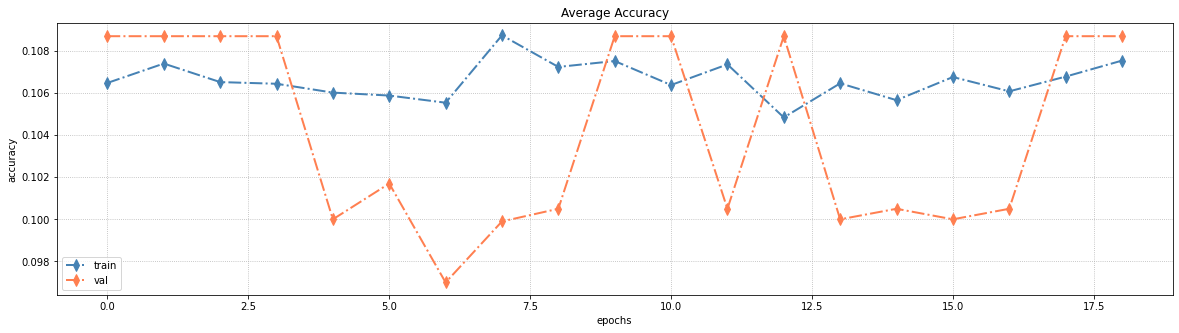

In [117]:
# plotting loss
fig, ax = plt.subplots(figsize=(20,5))
epochs = range(rms_nepochs)
ax.set_title('Average Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.xaxis.grid(True,ls='dotted')
ax.yaxis.grid(True,ls='dotted')
ax.plot(epochs, rms_tr_acc, label='train', color='steelblue', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.plot(epochs, rms_val_acc, label='val', color='coral', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.legend()

plt.show()

#### Discussion
---
talking points

#### Confusion Matrix

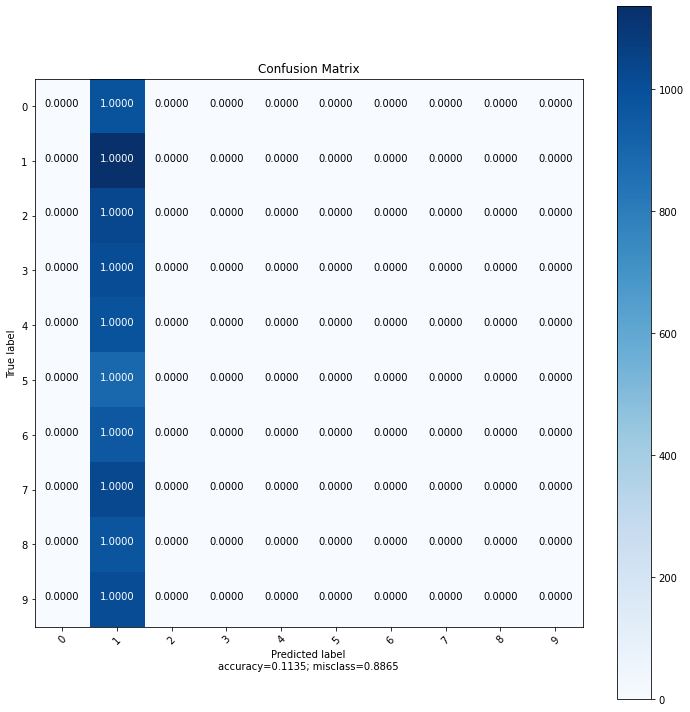

In [118]:
"""
inspiration for the code used below comes from these sources:

https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
"""

cf = metrics.confusion_matrix(rms_y_test, rms_pred)
plot_confusion_matrix(cf, range(10), title='Confusion Matrix')

### Adam

#### Learning Curves

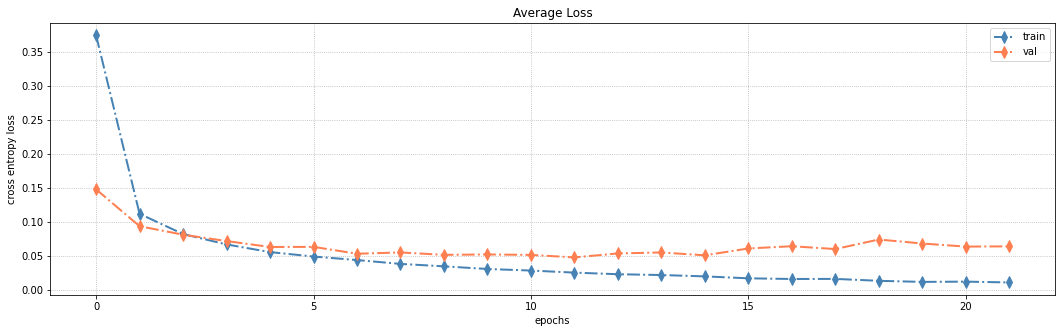

In [119]:
# plotting accuracy
fig, ax = plt.subplots(figsize=(18,5))
epochs = range(adam_nepochs)
ax.set_title('Average Loss')
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss')
ax.xaxis.grid(True,ls='dotted')
ax.yaxis.grid(True,ls='dotted')
ax.plot(epochs, adam_tr_loss, label='train', color='steelblue', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.plot(epochs, adam_val_loss, label='val', color='coral', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.legend()

plt.show()

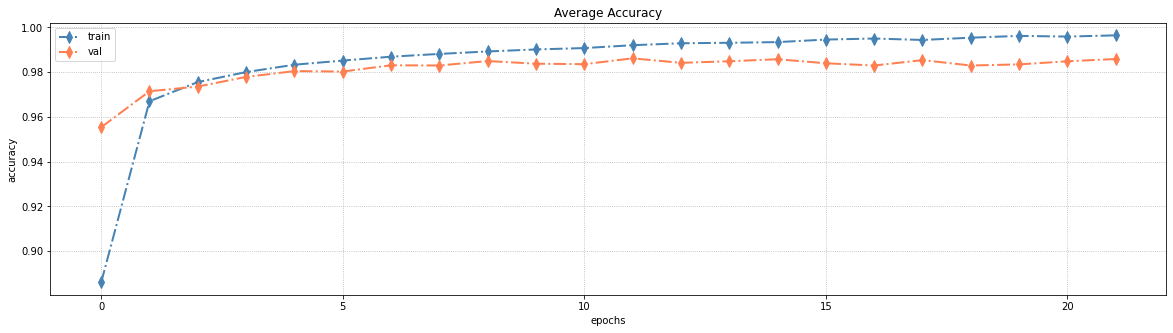

In [120]:
# plotting loss
fig, ax = plt.subplots(figsize=(20,5))
epochs = range(adam_nepochs)
ax.set_title('Average Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.xaxis.grid(True,ls='dotted')
ax.yaxis.grid(True,ls='dotted')
ax.plot(epochs, adam_tr_acc, label='train', color='steelblue', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.plot(epochs, adam_val_acc, label='val', color='coral', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.legend()

plt.show()

Discussion
---
As can be seen from the graph, the use of Adam optimization has helped the performance of the network. The accuracy of the network has gone up particularly for the validation set.  The accuracy of the original on the training data was 99% so that has not changed much, but Adam optimization has allowed the network to reduce the gap in performance between the training and validation sets. This suggests an increase in the generalization of the network.

#### Confusion Matrix

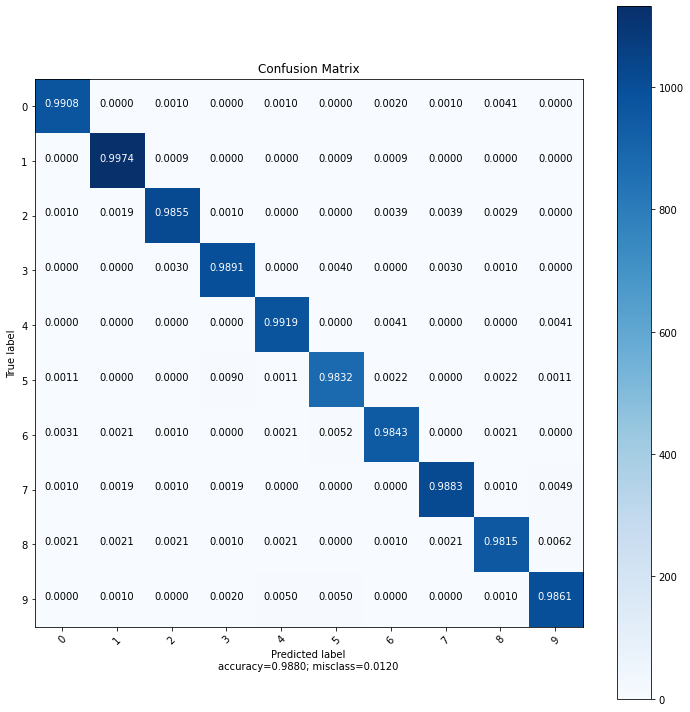

In [121]:
cf = metrics.confusion_matrix(adam_y_test, adam_pred)
plot_confusion_matrix(cf, range(10), title='Confusion Matrix')

### Nesterov

#### Learning Curves

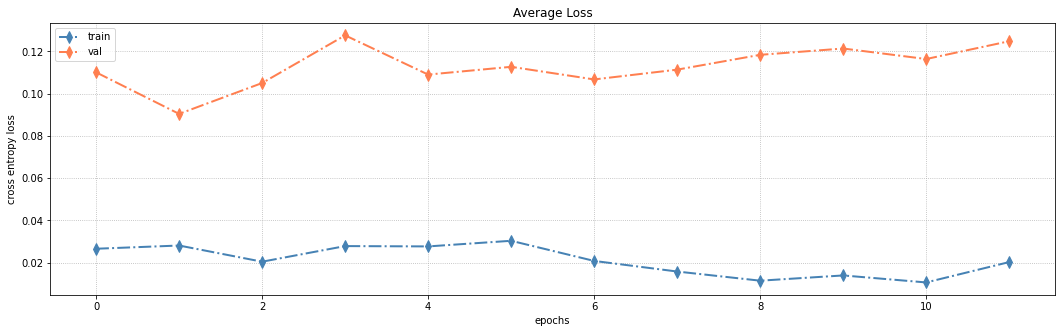

In [122]:
# plotting accuracy
fig, ax = plt.subplots(figsize=(18,5))
epochs = range(nest_nepochs)
ax.set_title('Average Loss')
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss')
ax.xaxis.grid(True,ls='dotted')
ax.yaxis.grid(True,ls='dotted')
ax.plot(epochs, nest_tr_loss, label='train', color='steelblue', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.plot(epochs, nest_val_loss, label='val', color='coral', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.legend()

plt.show()

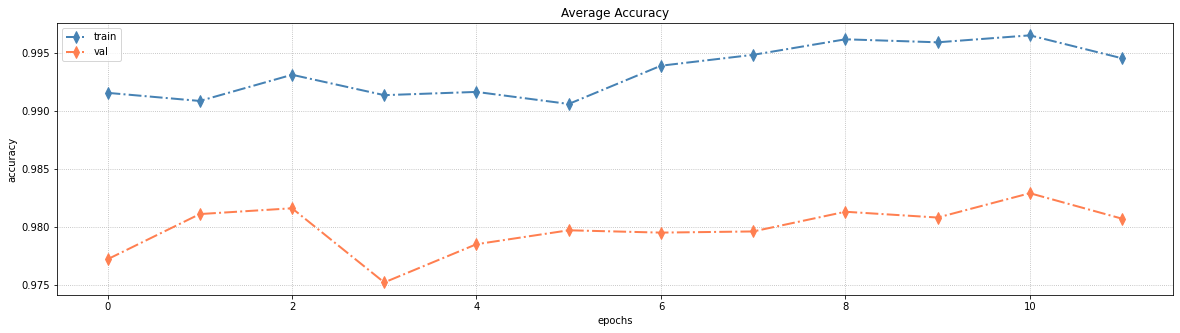

In [123]:
# plotting loss
fig, ax = plt.subplots(figsize=(20,5))
epochs = range(nest_nepochs)
ax.set_title('Average Accuracy')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.xaxis.grid(True,ls='dotted')
ax.yaxis.grid(True,ls='dotted')
ax.plot(epochs, nest_tr_acc, label='train', color='steelblue', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.plot(epochs, nest_val_acc, label='val', color='coral', marker='d', markersize=8, linestyle='dashdot', linewidth=2)
ax.legend()

plt.show()

Discussion
---
Although it did not get through many epochs, the network maintained a high rate of accuracy in the training and validation sets. In particular, the accuracy of the network on the training set maintained its level from the baseline model (and may have even increased). However, the network seems to have performed more poorly on the validation set than before, meaning its ability to generalize has been hurt.  This implies the network is overfitting to the training data as it continues to maintain a high level of accuracy with that set.

#### Confusion Matrix

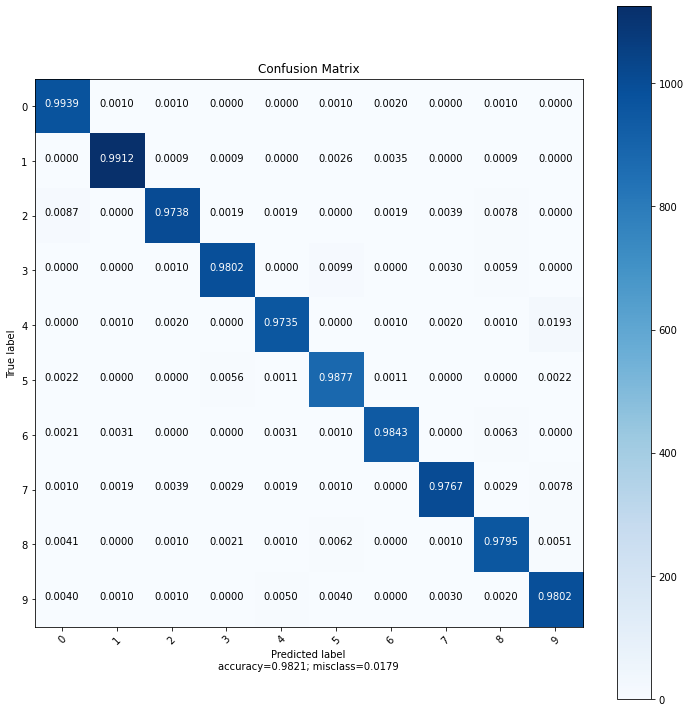

In [124]:
cf = metrics.confusion_matrix(nest_y_test, nest_pred)
plot_confusion_matrix(cf, range(10), title='Confusion Matrix')